# **Analyse des lignes de bus : Optimisation et scénarios**
**Auteur** : Maxime Delplanque  
**Objectif** : Analyser et optimiser les lignes de bus à partir de données de demande et de réseau.  

---
### **Sommaire**
1. [Import des bibliothèques](#1.-Import-des-bibliothèques)
2. [Chargement des données](#2.-Chargement-des-données)
3. [Prétraitement des données](#3.-Prétraitement-des-données)
4. [Diagnostic des lignes de bus](#4.-Diagnostic-des-lignes-de-bus)
5. [Analyse des paires OD](#5.-Analyse-des-paires-OD)
6. [Création des scénarios de lignes](#6.-Création-des-scénarios-de-lignes)
7. [Analyse comparative](#7.-Analyse-comparative)
8. [Réseau personnalisé](#8.-Réseau-personnalisé)
9. [Conclusion](#9.-Conclusion)


In [1]:
# ============================================================================
# **1. Import des bibliothèques**
# ============================================================================
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import LineString, Point, Polygon, MultiLineString, box
from shapely.ops import linemerge
import matplotlib.gridspec as gridspec
import math
from sklearn.cluster import KMeans
import itertools

# Configuration initiale
np.random.seed(42)
print("✓ Bibliothèques importées avec succès")

✓ Bibliothèques importées avec succès


---
### **2. Chargement des données**
Seules les données nécessaires à l'analyse sont chargées.


In [2]:
# ============================================================================
# **2. Chargement des données**
# ============================================================================
# Charger les données
df_demand = pd.read_csv('../data/demand.csv')
df_link = pd.read_csv('../data/link.csv')
df_node = pd.read_csv('../data/node.csv')
df_settings = pd.read_csv('../data/settings.csv')

# Afficher un résumé
print("=" * 80)
print("RÉSUMÉ DES DONNÉES CHARGÉES")
print("=" * 80)
print(f"Nœuds : {len(df_node):,} enregistrements")
print(f"Liens : {len(df_link):,} enregistrements")
print(f"Demande : {len(df_demand):,} paires OD")
print("✓ Données chargées avec succès")

RÉSUMÉ DES DONNÉES CHARGÉES
Nœuds : 8,521 enregistrements
Liens : 30,747 enregistrements
Demande : 30,422 paires OD
✓ Données chargées avec succès


---
### **3. Prétraitement des données**
Conversion des géométries et création du graphe réseau.


In [3]:
# ============================================================================
# **3. Prétraitement des données**
# ============================================================================
# Fonction utilitaire pour parser les géométries
def parse_geometry(geom):
    if isinstance(geom, Point):
        return geom
    if isinstance(geom, str):
        try:
            return wkt.loads(geom)
        except:
            raise ValueError(f"Impossible de parser la géométrie : {geom}")
    return geom

# Convertir les nœuds en GeoDataFrame
df_node['geometry_obj'] = df_node['geometry'].apply(parse_geometry)
nodes_gdf = gpd.GeoDataFrame(df_node, geometry='geometry_obj', crs='EPSG:4326')
print(f"✓ Nœuds convertis en GeoDataFrame : {len(nodes_gdf)} nœuds")

# Convertir les liens en GeoDataFrame
df_link['geometry_obj'] = df_link['geometry'].apply(parse_geometry)
links_gdf = gpd.GeoDataFrame(df_link, geometry='geometry_obj', crs='EPSG:4326')
print(f"✓ Liens convertis en GeoDataFrame : {len(links_gdf)} liens")

# Créer le graphe
G = nx.DiGraph()
for _, row in df_node.iterrows():
    G.add_node(row['node_id'], zone_id=row.get('zone_id'), x_coord=row['x_coord'], y_coord=row['y_coord'])

for _, row in df_link.iterrows():
    G.add_edge(
        row['from_node_id'],
        row['to_node_id'],
        link_id=row['link_id'],
        length=row['length'],
        free_speed=row['free_speed'],
        lanes=row['lanes'],
        capacity=row['capacity'],
        link_type=row.get('link_type')
    )

print(f"✓ Graphe créé : {G.number_of_nodes():,} nœuds, {G.number_of_edges():,} liens")

# Créer les points de zone
zone_points = (
    nodes_gdf.dropna(subset=['zone_id'])
    .groupby('zone_id')['geometry_obj']
    .apply(lambda g: g.unary_union.centroid)
    .reset_index()
    .rename(columns={'geometry_obj': 'geometry'})
)
zone_points_gdf = gpd.GeoDataFrame(zone_points, geometry='geometry', crs=nodes_gdf.crs)
print(f"✓ Points de zone créés : {len(zone_points_gdf)} zones")

✓ Nœuds convertis en GeoDataFrame : 8521 nœuds
✓ Liens convertis en GeoDataFrame : 30747 liens
✓ Graphe créé : 8,521 nœuds, 30,747 liens
✓ Points de zone créés : 234 zones


C:\Users\maxde\AppData\Local\Temp\ipykernel_10608\3173176459.py:48: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  .apply(lambda g: g.unary_union.centroid)


In [4]:
# ============================================================================
# **Paramètres globaux**
# ============================================================================
nbr_top_corridors = 15          # Nombre de corridors à analyser
stop_spacing_m = 600            # Espacement entre les arrêts (m)
overlap_jaccard_max = 0.8       # Seuil de chevauchement pour éviter les doublons
catchment_radius_m = 500        # Rayon de bassin versant (m)
stop_catchment_radius_m = 400   # Rayon de dessin des arrêts (m)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']


In [5]:
# ============================================================================
# **4. Vérification de la cohérence des données**
# ============================================================================

# 1. Vérification des nœuds entre nodes_gdf et G
nodes_in_gdf = set(nodes_gdf['node_id'])
nodes_in_G = set(G.nodes())

print("=" * 60)
print("Vérification des nœuds :")
print("=" * 60)
print(f"Nombre de nœuds dans nodes_gdf : {len(nodes_in_gdf)}")
print(f"Nombre de nœuds dans G : {len(nodes_in_G)}")

# Nœuds manquants dans G
missing_in_G = nodes_in_gdf - nodes_in_G
if missing_in_G:
    print(f"⚠ {len(missing_in_G)} nœuds présents dans nodes_gdf mais manquants dans G (exemples : {list(missing_in_G)[:5]})")
else:
    print("✅ Tous les nœuds de nodes_gdf sont présents dans G.")

# Nœuds manquants dans nodes_gdf
missing_in_gdf = nodes_in_G - nodes_in_gdf
if missing_in_gdf:
    print(f"⚠ {len(missing_in_gdf)} nœuds présents dans G mais manquants dans nodes_gdf (exemples : {list(missing_in_gdf)[:5]})")
else:
    print("✅ Tous les nœuds de G sont présents dans nodes_gdf.")

# 2. Vérification des zones entre zone_points_gdf et df_demand
print("\n" + "=" * 60)
print("Vérification des zones :")
print("=" * 60)

# Zones uniques dans zone_points_gdf
zones_in_zone_points = set(zone_points_gdf['zone_id'].unique())
print(f"Zones uniques dans zone_points_gdf : {len(zones_in_zone_points)}")

# Zones uniques dans df_demand (origine et destination)
zones_in_demand = set(df_demand['o_zone_id'].unique()).union(set(df_demand['d_zone_id'].unique()))
print(f"Zones uniques dans df_demand : {len(zones_in_demand)}")

# Zones manquantes dans zone_points_gdf
missing_zones_in_zone_points = zones_in_demand - zones_in_zone_points
if missing_zones_in_zone_points:
    print(f"⚠ {len(missing_zones_in_zone_points)} zones présentes dans df_demand mais manquantes dans zone_points_gdf (exemples : {list(missing_zones_in_zone_points)[:5]})")
else:
    print("✅ Toutes les zones de df_demand sont présentes dans zone_points_gdf.")

# Zones manquantes dans df_demand
missing_zones_in_demand = zones_in_zone_points - zones_in_demand
if missing_zones_in_demand:
    print(f"⚠ {len(missing_zones_in_demand)} zones présentes dans zone_points_gdf mais inutilisées dans df_demand (exemples : {list(missing_zones_in_demand)[:5]})")
else:
    print("✅ Toutes les zones de zone_points_gdf sont utilisées dans df_demand.")

# 3. Vérification des liens dans df_link et G
print("\n" + "=" * 60)
print("Vérification des liens :")
print("=" * 60)

# Nombre de liens dans df_link
links_in_df = len(df_link)
print(f"Nombre de liens dans df_link : {links_in_df}")

# Nombre de liens dans G
links_in_G = len(G.edges())
print(f"Nombre de liens dans G : {links_in_G}")

if links_in_df != links_in_G:
    print(f"⚠ Le nombre de liens dans df_link ({links_in_df}) ne correspond pas à celui dans G ({links_in_G}).")
else:
    print("✅ Le nombre de liens dans df_link correspond à celui dans G.")


Vérification des nœuds :
Nombre de nœuds dans nodes_gdf : 8521
Nombre de nœuds dans G : 8521
✅ Tous les nœuds de nodes_gdf sont présents dans G.
✅ Tous les nœuds de G sont présents dans nodes_gdf.

Vérification des zones :
Zones uniques dans zone_points_gdf : 234
Zones uniques dans df_demand : 234
✅ Toutes les zones de df_demand sont présentes dans zone_points_gdf.
✅ Toutes les zones de zone_points_gdf sont utilisées dans df_demand.

Vérification des liens :
Nombre de liens dans df_link : 30747
Nombre de liens dans G : 30747
✅ Le nombre de liens dans df_link correspond à celui dans G.


---
### **4. Fonctions utilitaires**
Fonctions réutilisables pour les calculs et visualisations.


In [6]:
def nearest_node(point_wgs84, nodes_gdf_proj):
    """Trouve le nœud le plus proche d'un point donné, en vérifiant qu'il existe dans nodes_gdf et G."""
    pt_proj = gpd.GeoSeries([point_wgs84], crs=nodes_gdf.crs).to_crs(3857).iloc[0]
    dists = nodes_gdf_proj.geometry.distance(pt_proj)

    # Trouver l'index du nœud le plus proche
    nearest_idx = dists.idxmin()
    nearest_node_id = nodes_gdf.loc[nearest_idx, 'node_id']

    # Vérifier que le nœud existe dans nodes_gdf et G
    if nearest_node_id not in nodes_gdf['node_id'].values:
        raise ValueError(f"Le nœud {nearest_node_id} n'existe pas dans nodes_gdf.")
    if nearest_node_id not in G.nodes():
        raise ValueError(f"Le nœud {nearest_node_id} n'existe pas dans le graphe G.")

    return nearest_node_id

def edge_time(u, v, data):
    """Calcule le temps de traversée d'un lien."""
    length = data.get('length', 1)
    fs = data.get('free_speed', 1)
    return length / (fs if fs and fs > 0 else 1e-3)

def jaccard(a, b):
    """Calcule la similarité de Jaccard entre deux ensembles."""
    inter = len(a & b)
    union = len(a | b) if (a | b) else 1
    return inter / union

def calculate_path_length(G, path_nodes):
    """Calcule la longueur totale d'un chemin."""
    return sum(G[u][v].get('length', 0) for u, v in zip(path_nodes[:-1], path_nodes[1:]))

def line_and_stops_from_path(path_nodes, nodes_gdf, stop_spacing_m):
    """Génère une ligne et des arrêts à partir d'un chemin."""
    pts = [nodes_gdf.loc[nodes_gdf['node_id'] == n, 'geometry_obj'].iloc[0] for n in path_nodes]
    line_geom = LineString(pts)
    line_proj = gpd.GeoSeries([line_geom], crs=nodes_gdf.crs).to_crs(3857).iloc[0]
    total_length_m = line_proj.length
    n_stops = max(2, int(total_length_m // stop_spacing_m) + 1)
    stops = [line_geom.interpolate(i / (n_stops - 1), normalized=True) for i in range(n_stops)]
    stops_gs = gpd.GeoSeries(stops, crs=nodes_gdf.crs)
    return line_geom, stops_gs, total_length_m


---
### **5. Analyse des paires OD**
Identification des paires origine-destination (OD) les plus demandées.


✓ No bus lines detected in the network data


C:\Users\maxde\AppData\Local\Temp\ipykernel_10608\621769733.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  .apply(lambda g: g.unary_union.centroid)


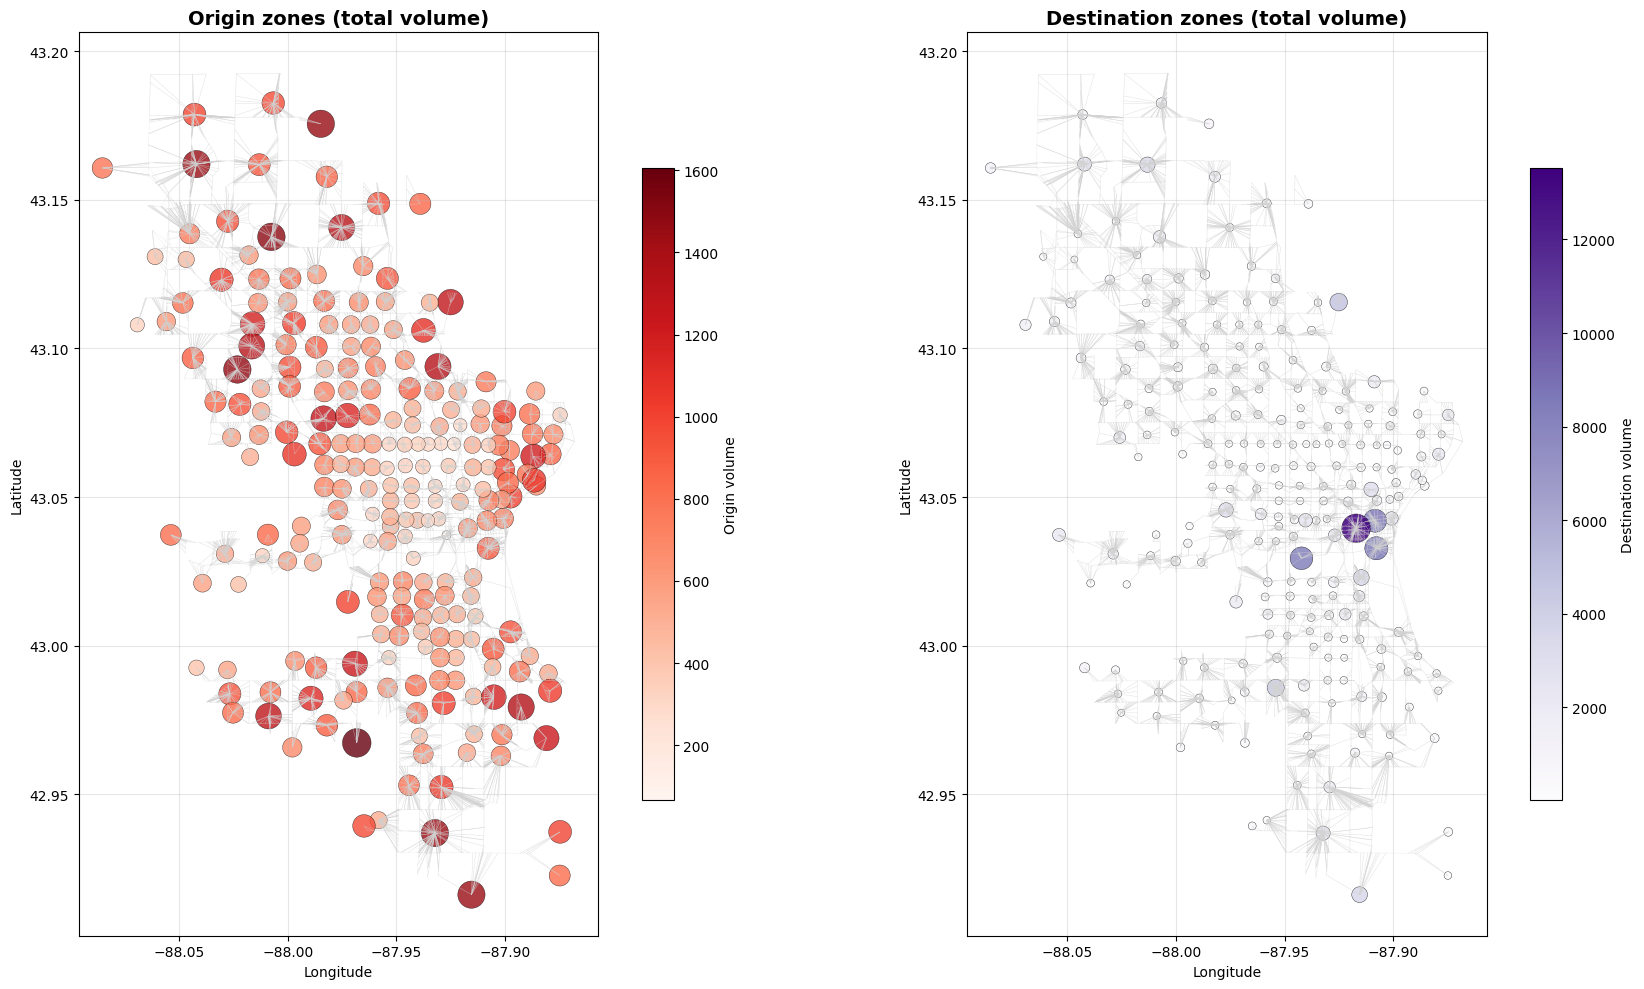

✓ Origin and destination zone maps generated


In [15]:
# Detect if bus lines exist in data
if 'bus_line_id' in df_link.columns and df_link['bus_line_id'].notnull().any():
    bus_lines_exist = True
    print("✓ Bus lines detected in the network data")
else:
    bus_lines_exist = False
    print("✓ No bus lines detected in the network data")
# Display maps with origin and destination densities

origin_volume = df_demand.groupby('o_zone_id')['volume'].sum().rename('origin_volume')
destination_volume = df_demand.groupby('d_zone_id')['volume'].sum().rename('destination_volume')

# Create representative zone points from nodes (zone centroid)
zone_points = (
    nodes_gdf.dropna(subset=['zone_id'])
    .groupby('zone_id')['geometry_obj']
    .apply(lambda g: g.unary_union.centroid)
    .reset_index()
    .rename(columns={'geometry_obj': 'geometry'})
)
zone_points_gdf = gpd.GeoDataFrame(zone_points, geometry='geometry', crs=nodes_gdf.crs)

# Join volumes
zone_points_gdf = zone_points_gdf.merge(origin_volume, left_on='zone_id', right_index=True, how='left')
zone_points_gdf = zone_points_gdf.merge(destination_volume, left_on='zone_id', right_index=True, how='left')
zone_points_gdf[['origin_volume', 'destination_volume']] = zone_points_gdf[['origin_volume', 'destination_volume']].fillna(0)

# Marker sizes scaled (square root to limit extremes)
max_origin = max(1, zone_points_gdf['origin_volume'].max())
max_dest = max(1, zone_points_gdf['destination_volume'].max())
zone_points_gdf['origin_size'] = 25 + 400 * zone_points_gdf['origin_volume'] / max_origin
zone_points_gdf['dest_size'] = 25 + 400 * zone_points_gdf['destination_volume'] / max_dest

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Origin map
links_gdf.plot(ax=axes[0], color='lightgray', linewidth=0.3, alpha=0.4)
zone_points_gdf.plot(
    ax=axes[0],
    column='origin_volume',
    cmap='Reds',
    markersize=zone_points_gdf['origin_size'],
    alpha=0.8,
    edgecolor='black',
    linewidth=0.3,
    legend=True,
    legend_kwds={'label': 'Origin volume', 'shrink': 0.7}
)
axes[0].set_title('Origin zones (total volume)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].grid(True, alpha=0.3)

# Destination map
links_gdf.plot(ax=axes[1], color='lightgray', linewidth=0.3, alpha=0.4)
zone_points_gdf.plot(
    ax=axes[1],
    column='destination_volume',
    cmap='Purples',  # darker palette to stand out on light background
    markersize=zone_points_gdf['dest_size'],
    alpha=0.85,
    edgecolor='black',
    linewidth=0.3,
    legend=True,
    legend_kwds={'label': 'Destination volume', 'shrink': 0.7}
)
axes[1].set_title('Destination zones (total volume)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Origin and destination zone maps generated")

C:\Users\maxde\AppData\Local\Temp\ipykernel_10608\239598487.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  .apply(lambda g: g.unary_union.centroid)


TOP 15 MEILLEURES PAIRES OD PAR VOLUME
 1. Zone   7 → Zone  67 | Volume :        202
 2. Zone  48 → Zone  49 | Volume :        181
 3. Zone 220 → Zone  67 | Volume :        161
 4. Zone  49 → Zone  48 | Volume :        156
 5. Zone 139 → Zone  67 | Volume :        153
 6. Zone  14 → Zone  49 | Volume :        153
 7. Zone  47 → Zone  49 | Volume :        152
 8. Zone  19 → Zone  49 | Volume :        149
 9. Zone 190 → Zone  67 | Volume :        148
10. Zone  67 → Zone  49 | Volume :        146
11. Zone 206 → Zone  67 | Volume :        137
12. Zone  82 → Zone  41 | Volume :        136
13. Zone  46 → Zone  49 | Volume :        135
14. Zone  10 → Zone  49 | Volume :        134
15. Zone 193 → Zone  67 | Volume :        124


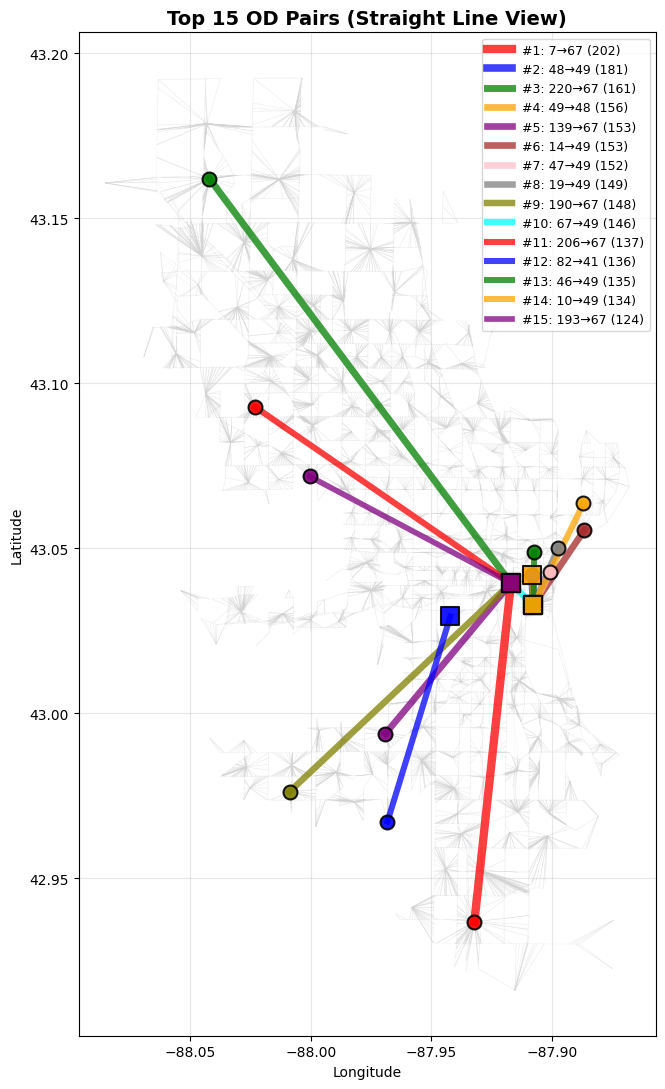

In [7]:
# Créer les points de zone
zone_points = (
    nodes_gdf.dropna(subset=['zone_id'])
    .groupby('zone_id')['geometry_obj']
    .apply(lambda g: g.unary_union.centroid)
    .reset_index()
    .rename(columns={'geometry_obj': 'geometry'})
)
zone_points_gdf = gpd.GeoDataFrame(zone_points, geometry='geometry', crs=nodes_gdf.crs)

# Calculer les volumes d'origine et de destination
origin_volume = df_demand.groupby('o_zone_id')['volume'].sum().rename('origin_volume')
destination_volume = df_demand.groupby('d_zone_id')['volume'].sum().rename('destination_volume')
zone_points_gdf = zone_points_gdf.merge(origin_volume, left_on='zone_id', right_index=True, how='left')
zone_points_gdf = zone_points_gdf.merge(destination_volume, left_on='zone_id', right_index=True, how='left')
zone_points_gdf[['origin_volume', 'destination_volume']] = zone_points_gdf[['origin_volume', 'destination_volume']].fillna(0)

# Top paires OD par volume
od_top = (
    df_demand.groupby(['o_zone_id', 'd_zone_id'])['volume']
    .sum()
    .reset_index()
    .sort_values('volume', ascending=False)
    .head(nbr_top_corridors)
)

print("=" * 80)
print(f"TOP {nbr_top_corridors} MEILLEURES PAIRES OD PAR VOLUME")
print("=" * 80)
for idx, (_, row) in enumerate(od_top.iterrows(), 1):
    print(f"{idx:2d}. Zone {int(row['o_zone_id']):3d} → Zone {int(row['d_zone_id']):3d} | Volume : {row['volume']:>10,.0f}")

# Create straight-line map for top OD pairs
fig, ax = plt.subplots(figsize=(14, 11))
links_gdf.plot(ax=ax, color='lightgray', linewidth=0.3, alpha=0.3, edgecolor='gray')

zone_lookup = zone_points_gdf.set_index('zone_id')

# Draw straight lines between origin and destination zones
for idx, (_, row) in enumerate(od_top.iterrows()):
    o_zone = int(row['o_zone_id'])
    d_zone = int(row['d_zone_id'])
    vol = row['volume']
    
    if o_zone in zone_lookup.index and d_zone in zone_lookup.index:
        o_pt = zone_lookup.loc[o_zone, 'geometry']
        d_pt = zone_lookup.loc[d_zone, 'geometry']
        
        # Draw line with width proportional to volume
        line_width = 1 + 5 * (vol / od_top['volume'].max())
        ax.plot([o_pt.x, d_pt.x], [o_pt.y, d_pt.y], 
                color=colors[idx % len(colors)], linewidth=line_width, 
                alpha=0.75, label=f"#{idx+1}: {o_zone}→{d_zone} ({vol:,.0f})")
        
        # Mark origin and destination points
        ax.scatter([o_pt.x], [o_pt.y], color=colors[idx % len(colors)], s=100, marker='o', 
                  edgecolor='black', linewidth=1.5, zorder=5, alpha=0.9)
        ax.scatter([d_pt.x], [d_pt.y], color=colors[idx % len(colors)], s=150, marker='s', 
                  edgecolor='black', linewidth=1.5, zorder=5, alpha=0.9)

ax.set_title(f'Top {nbr_top_corridors} OD Pairs (Straight Line View)', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=9)
plt.tight_layout()
plt.show()

---
### **6. Création des corridors**
Génération des lignes de bus basées sur la demande de bassin versant.


In [8]:
# Calculer la demande de bassin versant
def get_catchment_demand(zone_id, direction='origin', radius_m=catchment_radius_m):
    """Calcule la demande totale pour une zone et son bassin versant."""
    zone_centroid = zone_points_gdf.set_index('zone_id').loc[zone_id, 'geometry']
    nodes_proj = nodes_gdf.to_crs(3857)
    distances = nodes_proj.geometry.distance(zone_centroid)
    catchment_nodes = nodes_proj[distances <= radius_m]['node_id'].tolist()
    catchment_zones = df_node[df_node['node_id'].isin(catchment_nodes)]['zone_id'].unique()

    if direction == 'origin':
        return df_demand[df_demand['o_zone_id'].isin(catchment_zones)]['volume'].sum()
    else:
        return df_demand[df_demand['d_zone_id'].isin(catchment_zones)]['volume'].sum()

# Top paires OD par demande de bassin versant
od_top['catchment_demand'] = od_top.apply(
    lambda row: get_catchment_demand(row['o_zone_id'], 'origin') +
                get_catchment_demand(row['d_zone_id'], 'destination'),
    axis=1
)

od_top_catchment = od_top.sort_values('catchment_demand', ascending=False).head(nbr_top_corridors)

# Créer les corridors
corridors_catchment = []
kept_corridors = 0
nodes_proj = nodes_gdf.to_crs(3857)
G_working = G.copy()

for _, row in od_top_catchment.iterrows():
    if kept_corridors >= nbr_top_corridors:
        break

    o_zone, d_zone = int(row['o_zone_id']), int(row['d_zone_id'])
    o_pt = zone_points_gdf.set_index('zone_id').loc[o_zone, 'geometry']
    d_pt = zone_points_gdf.set_index('zone_id').loc[d_zone, 'geometry']

    source_node = nearest_node(o_pt, nodes_proj)
    target_node = nearest_node(d_pt, nodes_proj)

    try:
        path_nodes = nx.shortest_path(G_working, source=source_node, target=target_node, weight='length')
    except nx.NetworkXNoPath:
        continue

    line_geom, stops, length_m = line_and_stops_from_path(path_nodes, nodes_gdf, stop_spacing_m)
    path_set = set(path_nodes)

    if any(jaccard(path_set, c['path_set']) > overlap_jaccard_max for c in corridors_catchment):
        continue

    total_time_h = sum(edge_time(u, v, G.get_edge_data(u, v)) for u, v in zip(path_nodes[:-1], path_nodes[1:]))

    corridors_catchment.append({
        'o_zone': o_zone,
        'd_zone': d_zone,
        'direct_volume': row['volume'],
        'catchment_volume': row['catchment_demand'],
        'geometry': line_geom,
        'stops': stops,
        'length_m': length_m,
        'time_min': total_time_h * 60,
        'path_set': path_set,
    })
    kept_corridors += 1

print(f"✓ {len(corridors_catchment)} corridors créés basés sur la demande de bassin versant")


✓ 14 corridors créés basés sur la demande de bassin versant


---
### **7. Fréquentation des lignes**
Calcul de la fréquentation totale pour chaque ligne de bus.


In [9]:
def calculate_line_ridership(corridor, stop_radius_m=400):
    """
    Calcule la fréquentation totale d'une ligne de bus en considérant toutes les paires OD
    entre les zones desservies par les arrêts de la ligne.
    """
    stops_proj = gpd.GeoSeries(corridor['stops'], crs=nodes_gdf.crs).to_crs(3857)
    served_zones = set()

    for stop in stops_proj:
        distances = nodes_gdf.to_crs(3857).geometry.distance(stop)
        nearby_nodes = nodes_gdf[distances <= stop_radius_m]['node_id'].tolist()
        nearby_zones = nodes_gdf[nodes_gdf['node_id'].isin(nearby_nodes)]['zone_id'].dropna().unique()
        served_zones.update(nearby_zones)

    od_demand = df_demand[
        (df_demand['o_zone_id'].isin(served_zones)) &
        (df_demand['d_zone_id'].isin(served_zones))
    ]
    total_ridership = od_demand['volume'].sum()

    return total_ridership

for corridor in corridors_catchment:
    corridor['total_ridership'] = calculate_line_ridership(corridor)


---
### **8. Scénarios de lignes**
Création de différents scénarios de lignes de bus.


In [10]:
import itertools, math
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
from shapely import wkt
from sklearn.cluster import KMeans

# ---------- Helpers ----------
def choose_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"Aucune des colonnes {candidates} n'est présente dans le DataFrame")

def parse_geometry(geom):
    """Convertit une geometry en Point, gère les strings WKT"""
    if isinstance(geom, Point):
        return geom
    if isinstance(geom, str):
        try:
            return wkt.loads(geom)
        except:
            raise ValueError(f"Impossible de parser la geometry: {geom}")
    return geom

# cache coords for heuristic
node_xy = {}
for _, row in nodes_gdf.iterrows():
    geom = parse_geometry(row.geometry)
    node_xy[row['node_id']] = (geom.x, geom.y)

def path_length_m(G, path_nodes):
    L = 0.0
    for i in range(len(path_nodes) - 1):
        u, v = path_nodes[i], path_nodes[i+1]
        data = G[u][v]
        # MultiDiGraph: data = {key: attrs}; Graph simple: data = attrs
        if isinstance(data, dict) and 'length' not in data:
            # multi-edges → prendre la longueur min
            lengths = [attrs.get('length', 0.0) for attrs in data.values()]
            if lengths:
                L += min(lengths)
        else:
            L += data.get('length', 0.0)
    return L

def line_and_stops_from_path(path_nodes, nodes_lookup, stop_spacing_m):
    pts = []
    for n in path_nodes:
        geom = parse_geometry(nodes_lookup.loc[nodes_lookup['node_id'] == n].geometry.iloc[0])
        pts.append(geom)

    line_geom = LineString(pts)
    # Longueur en m via reprojection
    line_proj = gpd.GeoSeries([line_geom], crs=nodes_lookup.crs).to_crs(3857).iloc[0]
    total_length_m = line_proj.length
    n_stops = max(2, int(total_length_m / stop_spacing_m) + 1)
    # interpolation normalisée le long de la ligne
    stops = [line_geom.interpolate(i / (n_stops - 1), normalized=True) for i in range(n_stops)]
    stops_gs = gpd.GeoSeries(stops, crs=nodes_lookup.crs)
    return line_geom, stops_gs, total_length_m

def plot_scenario(corridors, title):
    fig = plt.figure(figsize=(18, 14))
    ax = fig.add_subplot(111)
    # base network
    links_gdf.plot(ax=ax, color='lightgray', linewidth=0.5, alpha=0.3, zorder=1)
    nodes_gdf.plot(ax=ax, color='lightgray', markersize=5, alpha=0.3, zorder=2)
    colors = plt.cm.tab20(np.linspace(0, 1, max(1, len(corridors))))
    for i, (corr, color) in enumerate(zip(corridors, colors), start=1):
        line_gdf = gpd.GeoDataFrame([{'geometry': corr['geometry']}], crs=nodes_gdf.crs)
        stops_gdf = gpd.GeoDataFrame(geometry=corr['stops'], crs=nodes_gdf.crs)
        # line + outline
        line_gdf.plot(ax=ax, color='white', linewidth=5, alpha=0.8, zorder=4)
        line_gdf.plot(ax=ax, color=color, linewidth=3, alpha=0.95, zorder=5)
        # stops
        stops_gdf.plot(ax=ax, color=color, markersize=70, alpha=0.95,
                       edgecolor='white', linewidth=1.6, marker='o', zorder=6)
        # O/D markers
        def ensure_point(obj):
            if isinstance(obj, Point):
                return obj
            return parse_geometry(obj)

        first_stop = ensure_point(corr['stops'].iloc[0])
        last_stop = ensure_point(corr['stops'].iloc[-1])
        ax.scatter([first_stop.x], [first_stop.y], s=180, marker='s', color=color,
                   edgecolor='black', linewidth=2, zorder=7, label=None)
        ax.scatter([last_stop.x], [last_stop.y], s=180, marker='^', color=color,
                   edgecolor='black', linewidth=2, zorder=7, label=None)
        # label
        mid_stop = ensure_point(corr['stops'].iloc[len(corr['stops']) // 2])
        ax.annotate(f'{i}', xy=(mid_stop.x, mid_stop.y), xytext=(0, 0), textcoords='offset points',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='circle,pad=0.3', facecolor=color, alpha=0.95,
                              edgecolor='black', linewidth=1.5),
                    color='white', ha='center', va='center', zorder=8)
    ax.set_title(title, fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout(); plt.show()

# ---------- Scenario K-Shortest Paths (k=2 => 2ème meilleure route) ----------
def create_lines_k_shortest_paths(top_corridors, G, nodes_lookup, stop_spacing_m, kth=2):
    out = []
    for c in top_corridors:
        o_zone = c['o_zone']; d_zone = c['d_zone']
        O = nodes_lookup[nodes_lookup['zone_id'] == o_zone]
        D = nodes_lookup[nodes_lookup['zone_id'] == d_zone]
        if O.empty or D.empty: continue
        s = O.iloc[0]['node_id']; t = D.iloc[0]['node_id']
        try:
            gen = nx.shortest_simple_paths(G, s, t, weight='length')
            k_paths = list(itertools.islice(gen, kth))  # prend jusqu'au kth chemin
            if not k_paths: continue
            path_nodes = k_paths[-1]
            L = path_length_m(G, path_nodes)
            line_geom, stops, Lm = line_and_stops_from_path(path_nodes, nodes_lookup, stop_spacing_m)
            out.append({
                'o_zone': o_zone, 'd_zone': d_zone,
                'direct_volume': c.get('direct_volume', 0),
                'catchment_volume': c.get('catchment_volume', 0),
                'geometry': line_geom, 'stops': stops,
                'length_m': Lm, 'path_nodes': path_nodes, 'path_rank': min(kth, len(k_paths))
            })
        except nx.NetworkXNoPath:
            continue
    return out

# ---------- Scenario A* Algorithm (heuristique euclidienne) ----------
def astar_euclidean(G, s, t, node_xy):
    tx, ty = node_xy[t]
    def h(n, target=None):
        x, y = node_xy[n]
        return math.hypot(tx - x, ty - y)
    return nx.astar_path(G, s, t, heuristic=h, weight='length')

def astar_euclidean(G, s, t, node_xy):
    tx, ty = node_xy[t]
    def h(u, v):
        x, y = node_xy[u]
        return math.hypot(tx - x, ty - y)
    return nx.astar_path(G, s, t, heuristic=h, weight='length')

def astar_custom_heuristic(G, s, t, node_xy):
    tx, ty = node_xy[t]
    def h(u, v):
        x, y = node_xy[u]
        # Ajoutez un facteur multiplicatif pour accentuer les différences
        return 2 * math.hypot(tx - x, ty - y)  # Facteur de 2
    return nx.astar_path(G, s, t, heuristic=h, weight='length')

def create_lines_astar_custom(top_corridors, G, nodes_lookup, stop_spacing_m):
    out = []
    for c in top_corridors:
        o_zone = c['o_zone']; d_zone = c['d_zone']
        O = nodes_lookup[nodes_lookup['zone_id'] == o_zone]
        D = nodes_lookup[nodes_lookup['zone_id'] == d_zone]
        if O.empty or D.empty: continue
        s = O.iloc[0]['node_id']; t = D.iloc[0]['node_id']
        try:
            path_nodes = astar_custom_heuristic(G, s, t, node_xy)
            L = path_length_m(G, path_nodes)
            line_geom, stops, Lm = line_and_stops_from_path(path_nodes, nodes_lookup, stop_spacing_m)
            out.append({
                'o_zone': o_zone, 'd_zone': d_zone,
                'direct_volume': c.get('direct_volume', 0),
                'catchment_volume': c.get('catchment_volume', 0),
                'geometry': line_geom, 'stops': stops,
                'length_m': Lm, 'path_nodes': path_nodes
            })
        except nx.NetworkXNoPath:
            continue
    return out

# ---------- Scenario Clustering-Based (passe par centres de demande) ----------
def nearest_nodes_to_centers(centers, nodes_lookup):
    chosen = []
    for cx, cy in centers:
        dmin, nid = float('inf'), None
        for _, r in nodes_lookup.iterrows():
            geom = parse_geometry(r.geometry)
            dx = geom.x - cx; dy = geom.y - cy
            d = dx*dx + dy*dy
            if d < dmin:
                dmin, nid = d, r['node_id']
        if nid is not None:
            chosen.append(nid)
    return chosen

def create_lines_clustering(top_corridors, G, nodes_lookup, zone_points, df_demand, stop_spacing_m,
                            n_clusters=2, top_zones=8):
    col_o = choose_col(df_demand, ['o_zone', 'o_zone_id'])
    col_d = choose_col(df_demand, ['d_zone', 'd_zone_id'])
    out = []
    for c in top_corridors:
        o_zone = c['o_zone']; d_zone = c['d_zone']
        O = nodes_lookup[nodes_lookup['zone_id'] == o_zone]
        D = nodes_lookup[nodes_lookup['zone_id'] == d_zone]
        if O.empty or D.empty: continue
        s = O.iloc[0]['node_id']; t = D.iloc[0]['node_id']

        od_from_o = df_demand[df_demand[col_o] == o_zone]
        od_to_d   = df_demand[df_demand[col_d] == d_zone]

        cand_zones = []
        if 'volume' in od_from_o.columns:
            cand_zones.extend(od_from_o.sort_values('volume', ascending=False)[col_d].head(top_zones).tolist())
        else:
            cand_zones.extend(od_from_o[col_d].tolist())
        if 'volume' in od_to_d.columns:
            cand_zones.extend(od_to_d.sort_values('volume', ascending=False)[col_o].head(top_zones).tolist())
        else:
            cand_zones.extend(od_to_d[col_o].tolist())

        cand_zones = [z for z in cand_zones if z not in (o_zone, d_zone)]
        cand_zones = list(dict.fromkeys(cand_zones))  # unique

        coords = []
        for z in cand_zones:
            zp = zone_points[zone_points['zone_id'] == z]
            if not zp.empty:
                p = parse_geometry(zp.iloc[0].geometry)
                coords.append([p.x, p.y])

        if len(coords) < 2:
            # fallback shortest path
            try:
                pn = nx.shortest_path(G, s, t, weight='length')
                L = path_length_m(G, pn)
                line_geom, stops, Lm = line_and_stops_from_path(pn, nodes_lookup, stop_spacing_m)
                out.append({
                    'o_zone': o_zone, 'd_zone': d_zone,
                    'direct_volume': c.get('direct_volume', 0),
                    'catchment_volume': c.get('catchment_volume', 0),
                    'geometry': line_geom, 'stops': stops,
                    'length_m': Lm, 'path_nodes': pn, 'n_intermediate': 0
                })
            except nx.NetworkXNoPath:
                pass
            continue

        k = min(n_clusters, len(coords))
        km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(coords)
        centers = km.cluster_centers_
        inter_nodes = nearest_nodes_to_centers(centers, nodes_lookup)
        # trier par distance à la source (simple et efficace)
        inter_nodes_sorted = sorted(
            inter_nodes,
            key=lambda nid: math.hypot(node_xy[nid][0] - node_xy[s][0],
                                       node_xy[nid][1] - node_xy[s][1])
        )

        waypoints = [s] + inter_nodes_sorted + [t]
        full_path, total_L, feasible = [], 0.0, True
        for i in range(len(waypoints) - 1):
            try:
                seg = nx.shortest_path(G, waypoints[i], waypoints[i+1], weight='length')
                if i > 0: seg = seg[1:]
                full_path.extend(seg)
                total_L += path_length_m(G, seg)
            except nx.NetworkXNoPath:
                feasible = False
                break
        if not feasible or len(full_path) < 2:
            continue

        line_geom, stops, Lm = line_and_stops_from_path(full_path, nodes_lookup, stop_spacing_m)
        out.append({
            'o_zone': o_zone, 'd_zone': d_zone,
            'direct_volume': c.get('direct_volume', 0),
            'catchment_volume': c.get('catchment_volume', 0),
            'geometry': line_geom, 'stops': stops,
            'length_m': Lm, 'path_nodes': full_path,
            'n_intermediate': len(inter_nodes_sorted)
        })
    return out

---
### **9. Visualisation des scénarios**
Comparaison visuelle des différents scénarios de lignes.


Base (Dijkstra + pénalisation): 14 lignes
K-Shortest Paths: 14 lignes
A* Algorithm: 14 lignes


c:\Users\maxde\anaconda3\envs\GMNS_Plus_Dataset\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxde\anaconda3\envs\GMNS_Plus_Dataset\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxde\anaconda3\envs\GMNS_Plus_Dataset\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxde\anaconda3\envs\GMNS_Plus_Dataset\Lib\site-packages\s

Clustering-Based: 14 lignes


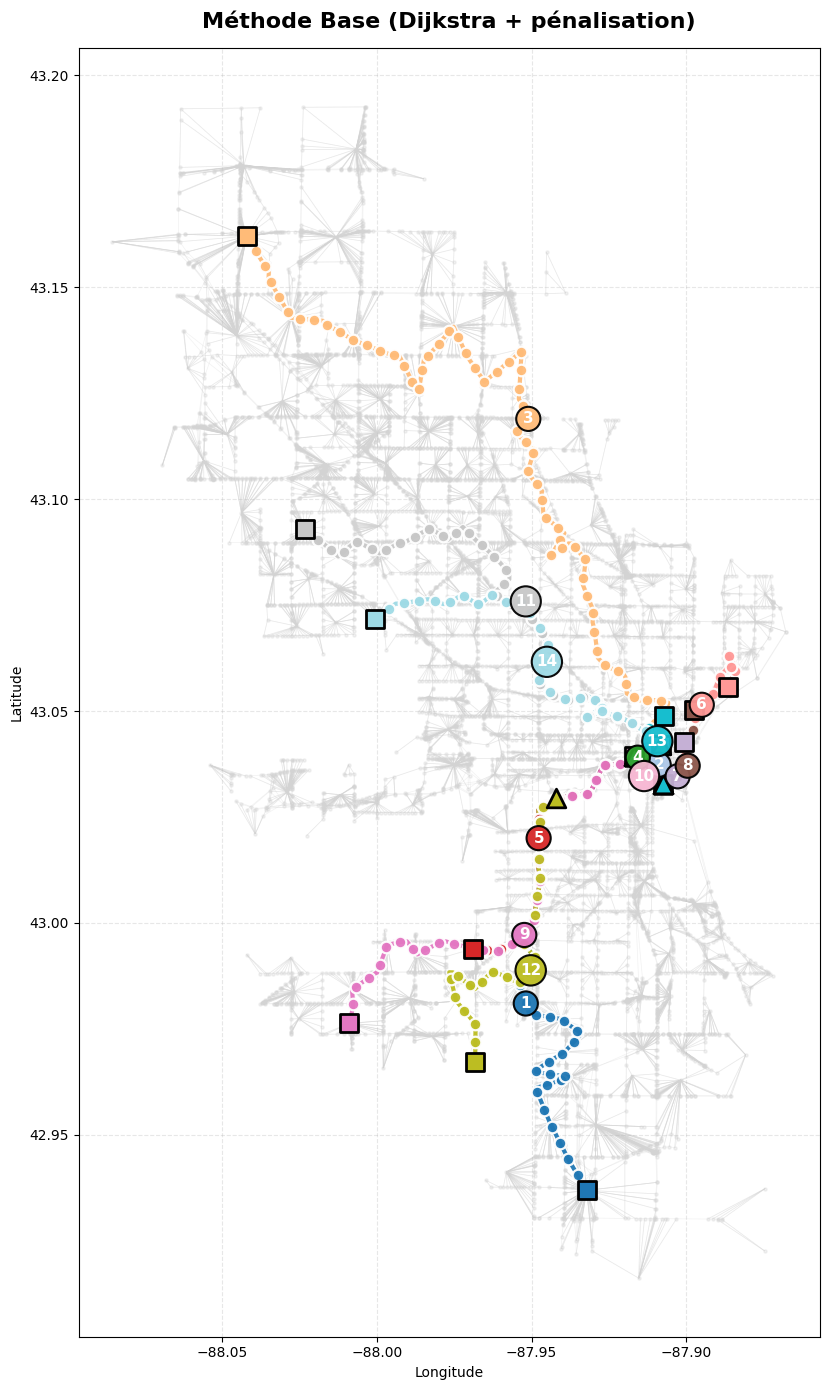

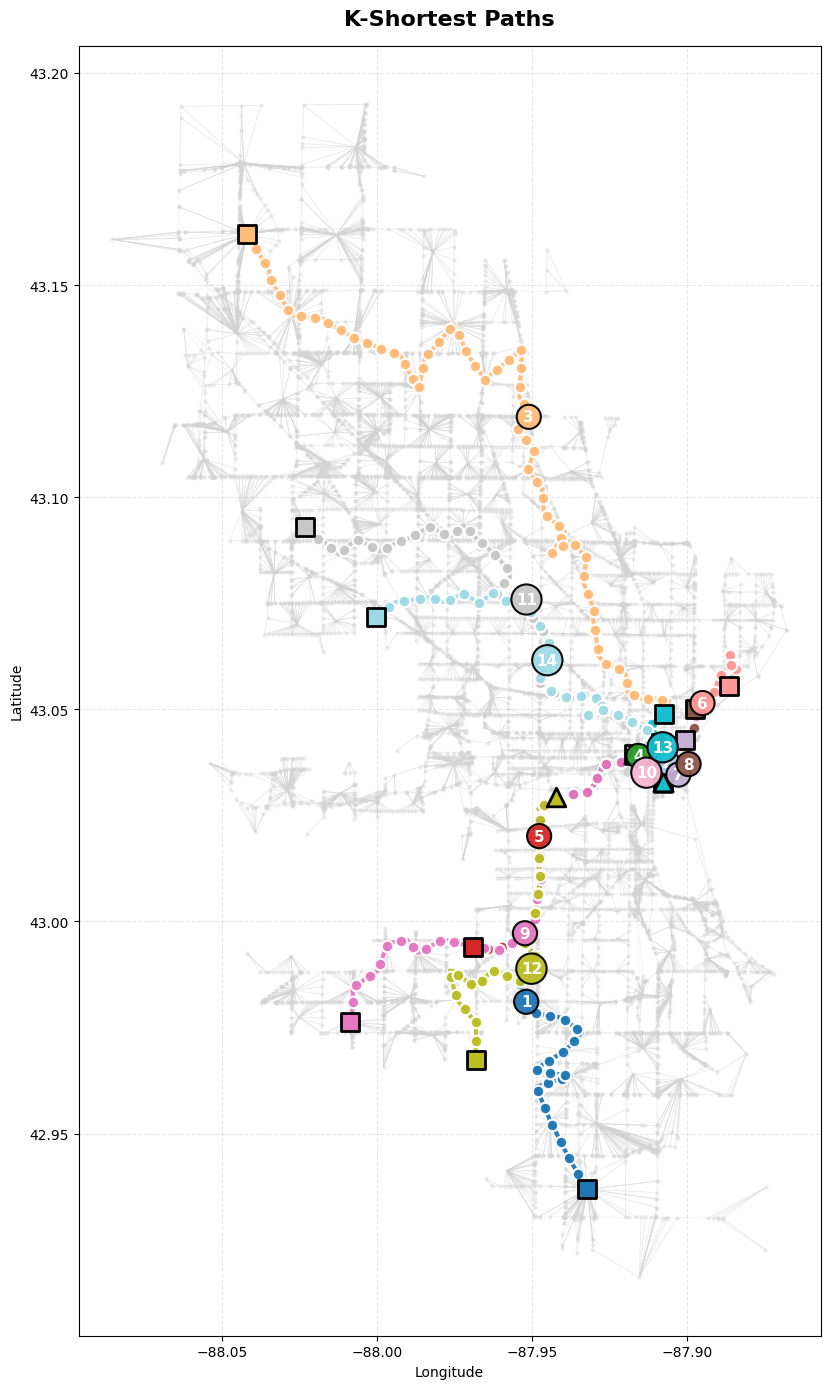

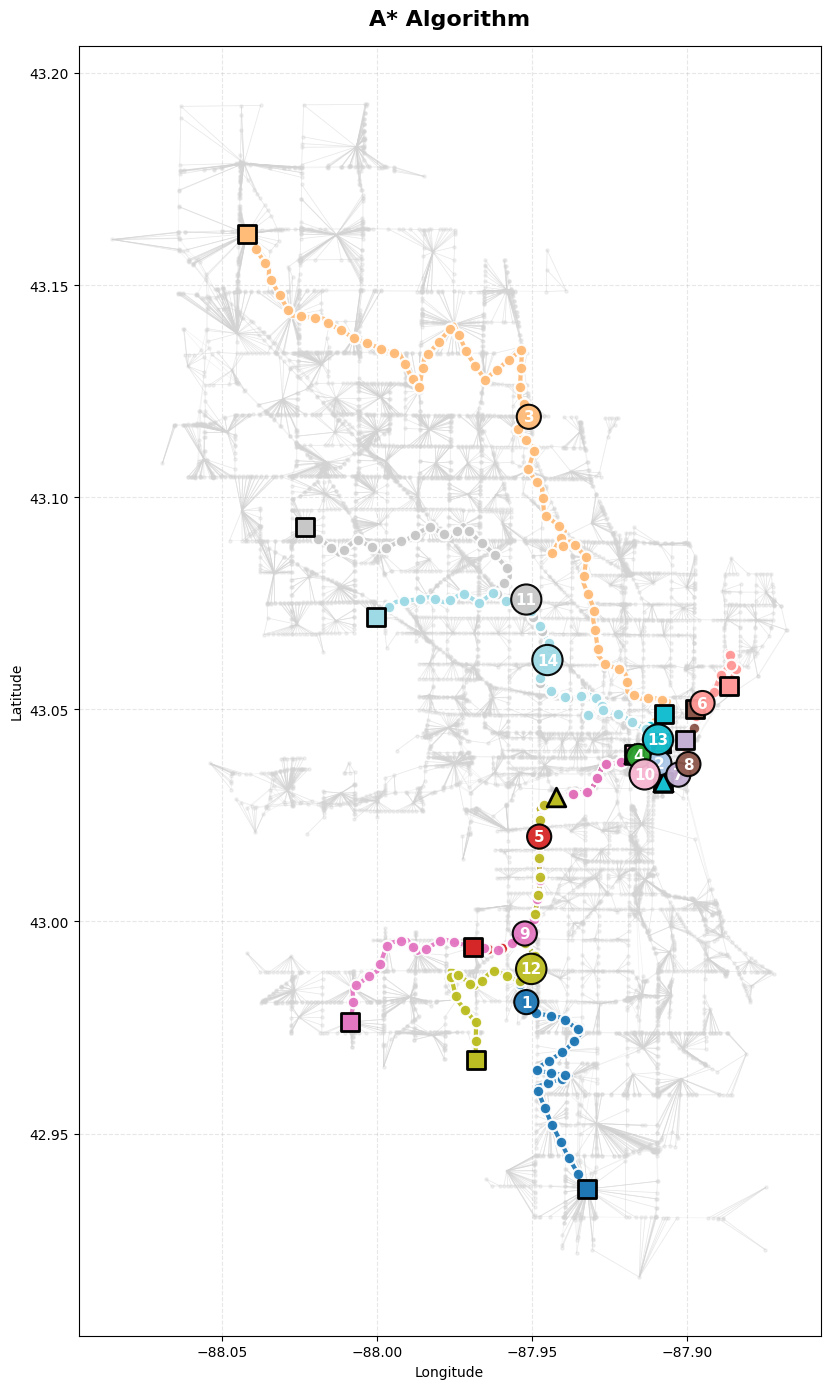

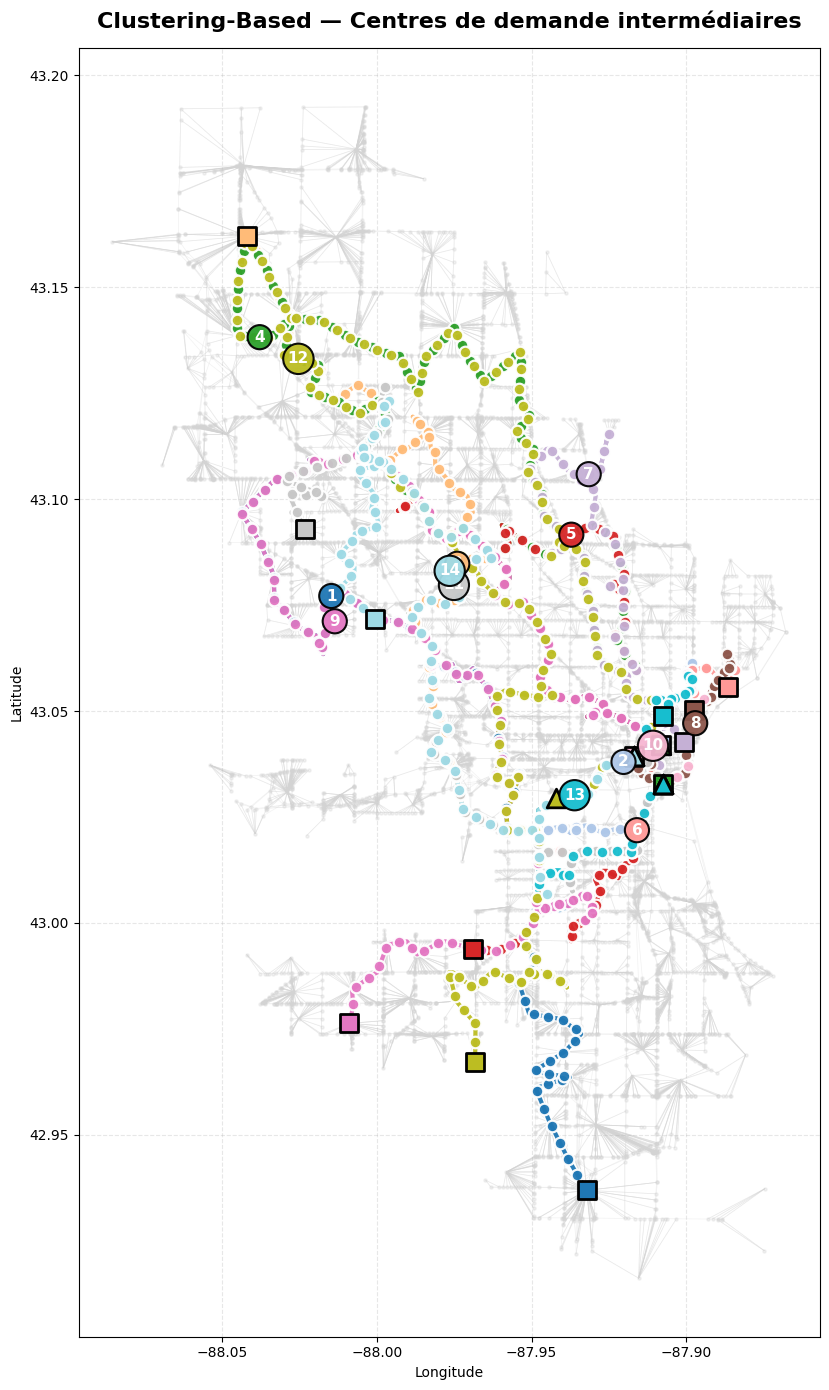

In [11]:
# ---------- 1) Scénario BASE (déjà créé) ----------
corridors_base = corridors_catchment  # réutilise la structure existante
print(f"Base (Dijkstra + pénalisation): {len(corridors_base)} lignes")

# ---------- 2) K-Shortest Paths (k=2 => 2ème meilleure route) ----------
corridors_k_paths = create_lines_k_shortest_paths(
    corridors_catchment, G, nodes_gdf, stop_spacing_m, kth=3
)
print(f"K-Shortest Paths: {len(corridors_k_paths)} lignes")

# ---------- 3) A* Algorithm (heuristique euclidienne) ----------
corridors_astar = create_lines_astar_custom(
    corridors_catchment, G, nodes_gdf, stop_spacing_m
)
print(f"A* Algorithm: {len(corridors_astar)} lignes")

# ---------- 4) Clustering-Based (passe par centres de demande) ----------
corridors_cluster = create_lines_clustering(
    corridors_catchment, G, nodes_gdf, zone_points, df_demand, stop_spacing_m,
    n_clusters=2, top_zones=8
)
print(f"Clustering-Based: {len(corridors_cluster)} lignes")

# ---------- Visualisations (une carte par méthode) ----------
plot_scenario(corridors_base, "Méthode Base (Dijkstra + pénalisation)")
plot_scenario(corridors_k_paths, "K-Shortest Paths")
plot_scenario(corridors_astar, "A* Algorithm")
plot_scenario(corridors_cluster, "Clustering-Based — Centres de demande intermédiaires")


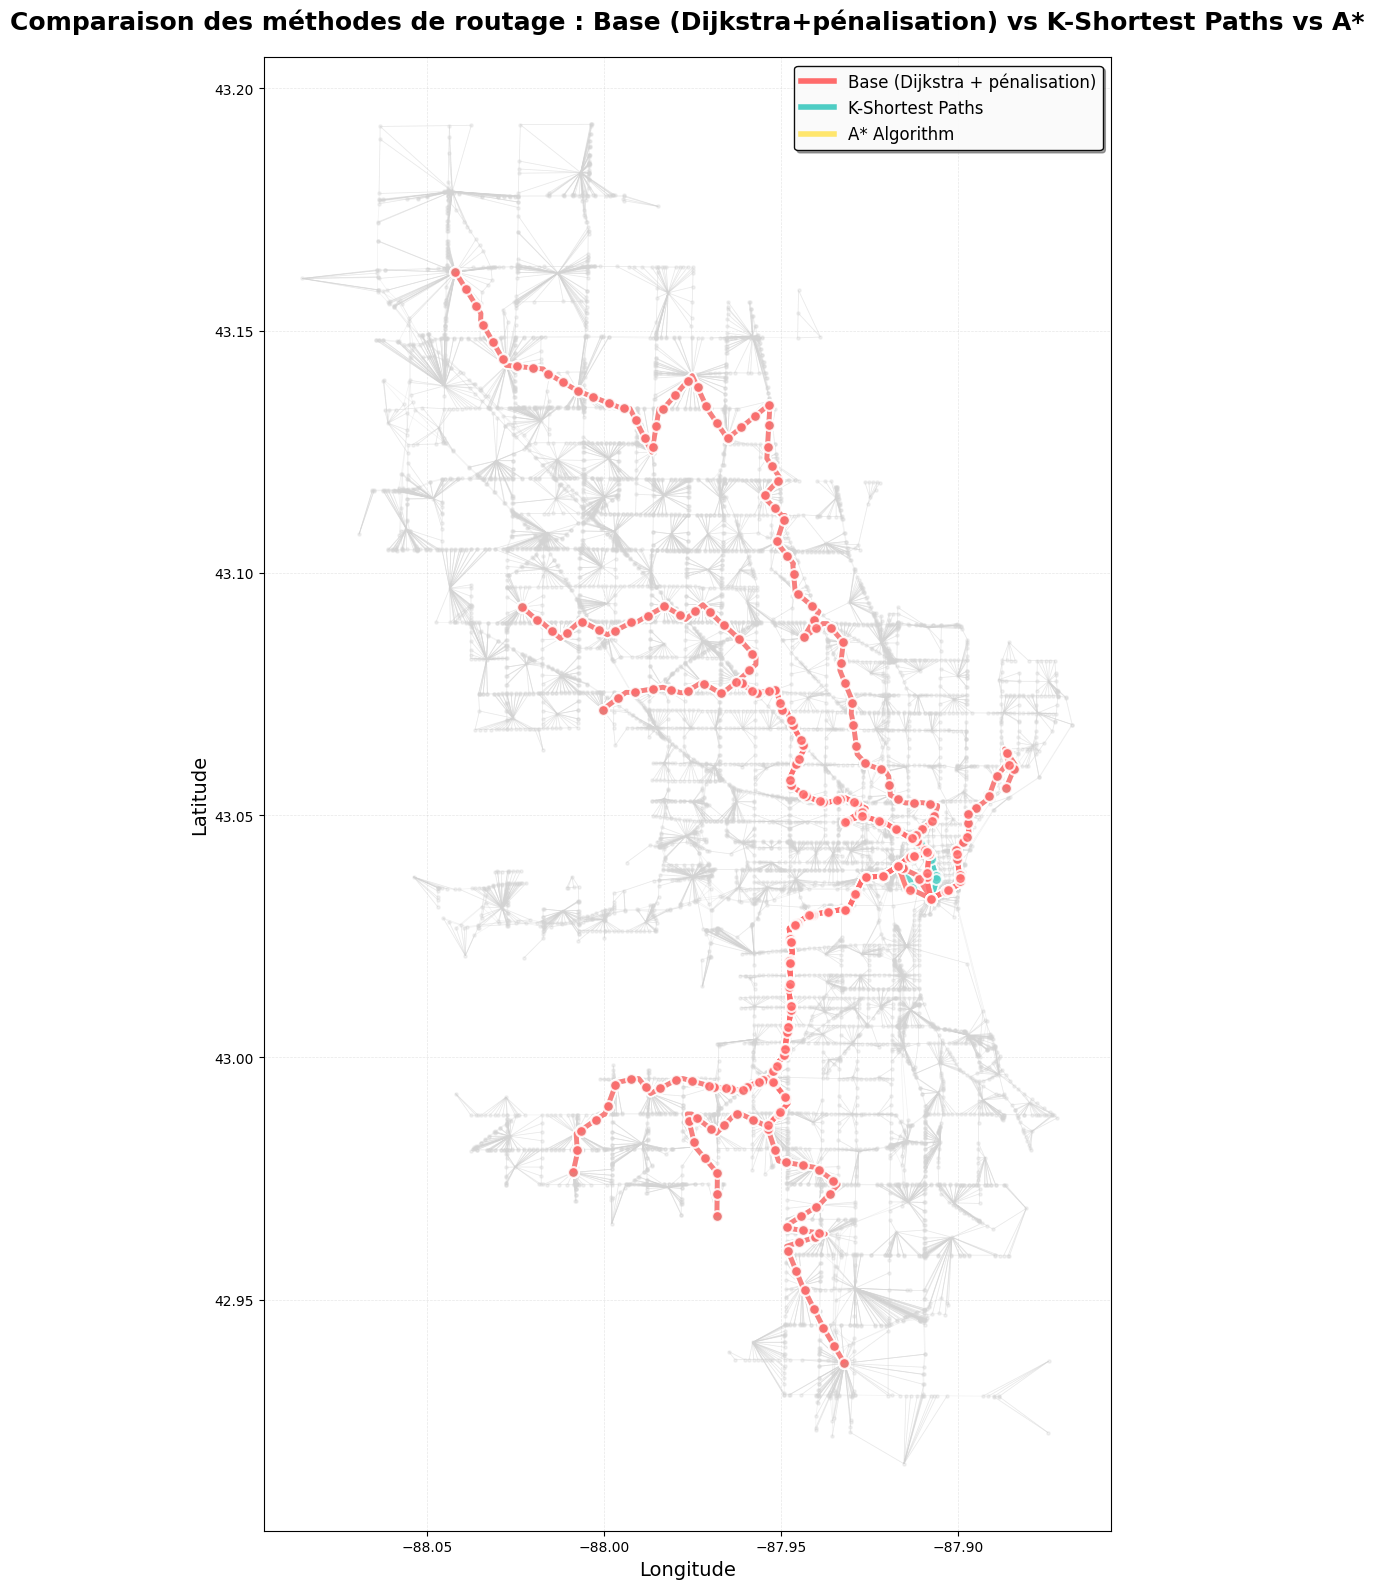


✅ Carte comparative affichée avec 14 lignes par méthode


In [12]:
# Carte superposant les trois méthodes : Base, K-Shortest et A*
fig, ax = plt.subplots(figsize=(20, 16))

# Afficher le réseau de base en gris clair
links_gdf.plot(ax=ax, color='lightgray', linewidth=0.5, alpha=0.3, zorder=1)
nodes_gdf.plot(ax=ax, color='lightgray', markersize=5, alpha=0.3, zorder=2)

# Définir les couleurs pour chaque méthode
colors_methods = {
    'Base': '#FF6B6B',      # Rouge
    'K-Shortest': '#4ECDC4', # Cyan
    'A*': '#FFE66D'          # Jaune
}

# Définir l'ordre de tracé (inversé pour que Base soit au-dessus)
methods_to_plot = [
    ('A*', corridors_astar, colors_methods['A*'], 3),
    ('K-Shortest', corridors_k_paths, colors_methods['K-Shortest'], 4),
    ('Base', corridors_base, colors_methods['Base'], 5)
]

# Tracer chaque méthode
for method_name, corridors, color, zorder in methods_to_plot:
    for i, corr in enumerate(corridors, start=1):
        line_gdf = gpd.GeoDataFrame([{'geometry': corr['geometry']}], crs=nodes_gdf.crs)
        stops_gdf = gpd.GeoDataFrame(geometry=corr['stops'], crs=nodes_gdf.crs)
        
        # Ligne avec contour blanc pour la visibilité
        line_gdf.plot(ax=ax, color='white', linewidth=6, alpha=0.7, zorder=zorder)
        line_gdf.plot(ax=ax, color=color, linewidth=3.5, alpha=0.85, zorder=zorder+1, label=method_name if i == 1 else "")
        
        # Arrêts
        stops_gdf.plot(ax=ax, color=color, markersize=60, alpha=0.85,
                      edgecolor='white', linewidth=1.5, marker='o', zorder=zorder+2)

# Configuration de la carte
ax.set_title('Comparaison des méthodes de routage : Base (Dijkstra+pénalisation) vs K-Shortest Paths vs A*', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Légende personnalisée
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=colors_methods['Base'], linewidth=4, label='Base (Dijkstra + pénalisation)'),
    Line2D([0], [0], color=colors_methods['K-Shortest'], linewidth=4, label='K-Shortest Paths'),
    Line2D([0], [0], color=colors_methods['A*'], linewidth=4, label='A* Algorithm')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12, framealpha=0.95, 
         edgecolor='black', fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

print(f"\n✅ Carte comparative affichée avec {len(corridors_base)} lignes par méthode")

---
### **10. Réseau personnalisé**
Création d'un réseau personnalisé à partir des scénarios.


Réseau personnalisé créé avec 7 lignes :
  Ligne 1: Base 1 - Zone 7 → Zone 67 | Longueur: 23192.55 m
  Ligne 2: Base 2 - Zone 220 → Zone 67 | Longueur: 36653.12 m
  Ligne 3: Base 3 - Zone 190 → Zone 67 | Longueur: 17881.87 m
  Ligne 4: Base 4 - Zone 206 → Zone 67 | Longueur: 22555.73 m
  Ligne 5: Base 5 - Zone 82 → Zone 41 | Longueur: 14211.62 m
  Ligne 6: Base 6 - Zone 193 → Zone 67 | Longueur: 17145.85 m
  Ligne 7: Base_6_then_inv10 - Zone 14 → Zone 67 | Longueur: 9033.47 m


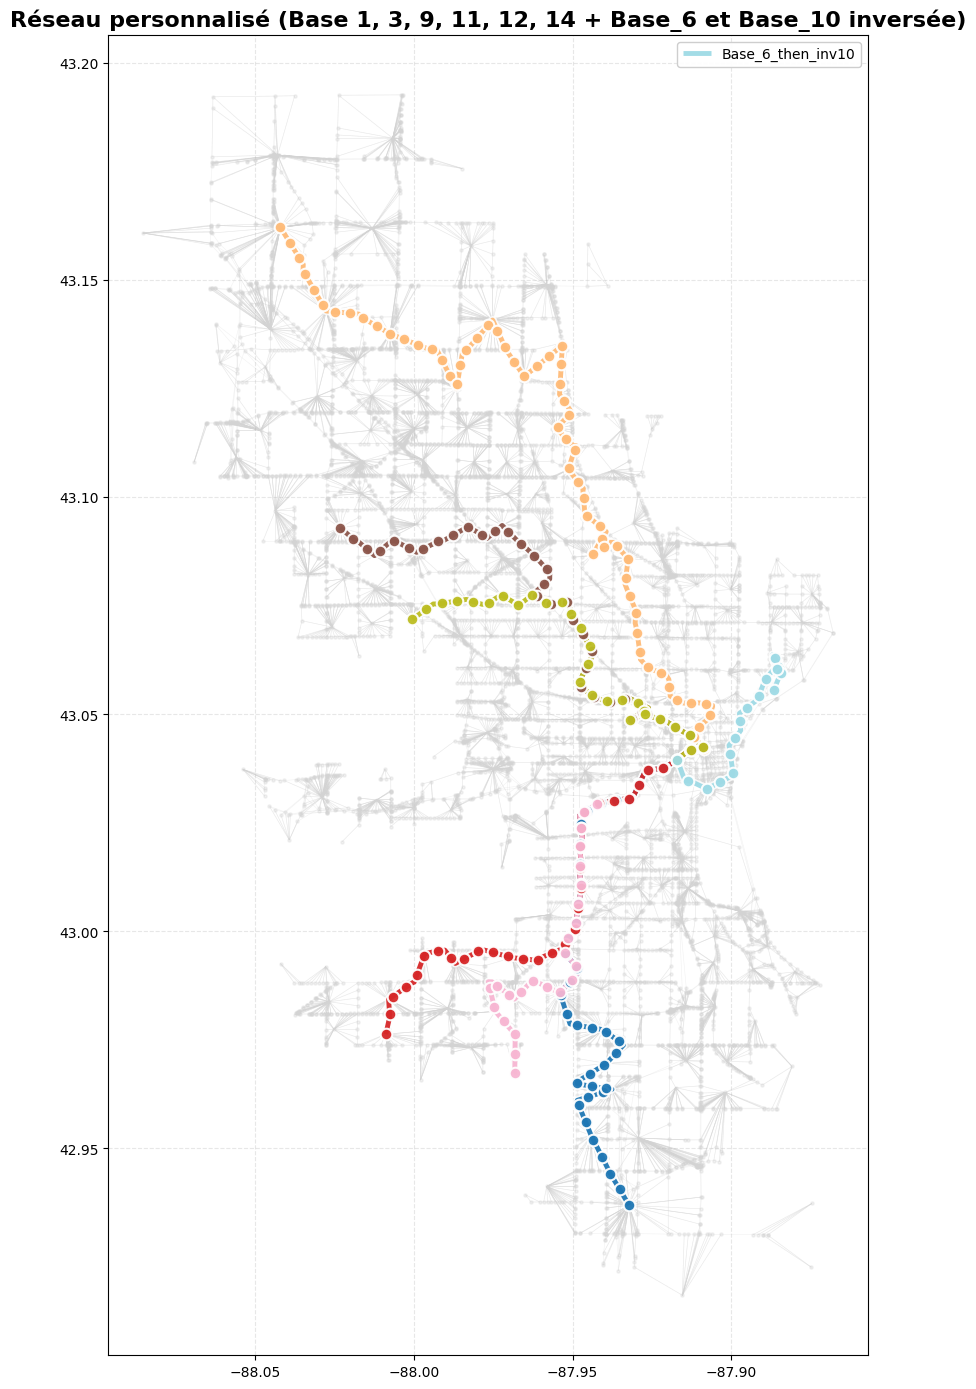

In [13]:
def reverse_corridor(corr):
    """Inverse un corridor (géométrie et arrêts)."""
    geom_rev = LineString(list(corr['geometry'].coords)[::-1])
    stops_rev = corr['stops'].iloc[::-1].reset_index(drop=True)
    path_rev = list(corr.get('path_nodes', []))[::-1] if 'path_nodes' in corr else []
    out = corr.copy()
    out['geometry'] = geom_rev
    out['stops'] = stops_rev
    if path_rev:
        out['path_nodes'] = path_rev
    out['o_zone'], out['d_zone'] = corr['d_zone'], corr['o_zone']
    return out

def fuse_corridors(c1, c2):
    """Fusionne deux corridors."""
    coords1 = list(c1['geometry'].coords)
    coords2 = list(c2['geometry'].coords)
    coords = coords1 + (coords2[1:] if coords1[-1] == coords2[0] else coords2)
    geom = LineString(coords)
    stops1 = list(c1['stops'])
    stops2 = list(c2['stops'])
    stops = stops1 + (stops2[1:] if stops1[-1] == stops2[0] else stops2)
    stops_gs = gpd.GeoSeries(stops, crs=c1['stops'].crs)
    geom_proj = gpd.GeoSeries([geom], crs=nodes_gdf.crs).to_crs(3857).iloc[0]
    fused = {
        'o_zone': c1['o_zone'],
        'd_zone': c2['d_zone'],
        'geometry': geom,
        'stops': stops_gs,
        'length_m': geom_proj.length,
    }
    return fused

# ============================================================================
# **Création du réseau personnalisé**
# ============================================================================

# Sélection des lignes 1, 3, 9, 11, 12 et 14 de la méthode de base
selected_base_lines = [corridors_base[i] for i in [0, 2, 8, 10, 11, 13]]  # Index 0, 2, 8, 10, 11, 13 correspondent aux lignes 1, 3, 9, 11, 12, 14

# Fusion des lignes 6 et 10 de la méthode de base (inverser la ligne 10)
line_6 = corridors_base[5]  # Index 5 correspond à la ligne 6
line_10_reversed = reverse_corridor(corridors_base[9])  # Index 9 correspond à la ligne 10
fused_line = fuse_corridors(line_6, line_10_reversed)
fused_line['name'] = "Base_6_then_inv10"

# Création du réseau personnalisé
custom_network = selected_base_lines + [fused_line]

# Affichage des informations sur le réseau personnalisé
print(f"Réseau personnalisé créé avec {len(custom_network)} lignes :")
for i, line in enumerate(custom_network):
    print(f"  Ligne {i+1}: {line.get('name', f'Base {i+1}')} - Zone {line['o_zone']} → Zone {line['d_zone']} | Longueur: {line['length_m']:.2f} m")

# ============================================================================
# **Visualisation du réseau personnalisé**
# ============================================================================

def plot_custom_network(net):
    colors = plt.cm.tab20(np.linspace(0, 1, len(net)))
    fig, ax = plt.subplots(figsize=(18, 14))
    links_gdf.plot(ax=ax, color='lightgray', linewidth=0.4, alpha=0.3, zorder=1)
    nodes_gdf.plot(ax=ax, color='lightgray', markersize=5, alpha=0.3, zorder=2)
    for corr, color in zip(net, colors):
        line_gdf = gpd.GeoDataFrame([{'geometry': corr['geometry']}], crs=nodes_gdf.crs)
        stops_gdf = gpd.GeoDataFrame(geometry=corr['stops'], crs=nodes_gdf.crs)
        line_gdf.plot(ax=ax, color='white', linewidth=6, alpha=0.8, zorder=4)
        line_gdf.plot(ax=ax, color=color, linewidth=3.5, alpha=0.95, zorder=5, label=corr.get('name', ''))
        stops_gdf.plot(ax=ax, color=color, markersize=70, alpha=0.95,
                       edgecolor='white', linewidth=1.5, marker='o', zorder=6)
    ax.set_title('Réseau personnalisé (Base 1, 3, 9, 11, 12, 14 + Base_6 et Base_10 inversée)', fontsize=16, fontweight='bold')
    ax.legend(loc='upper right', framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout(); plt.show()

plot_custom_network(custom_network)


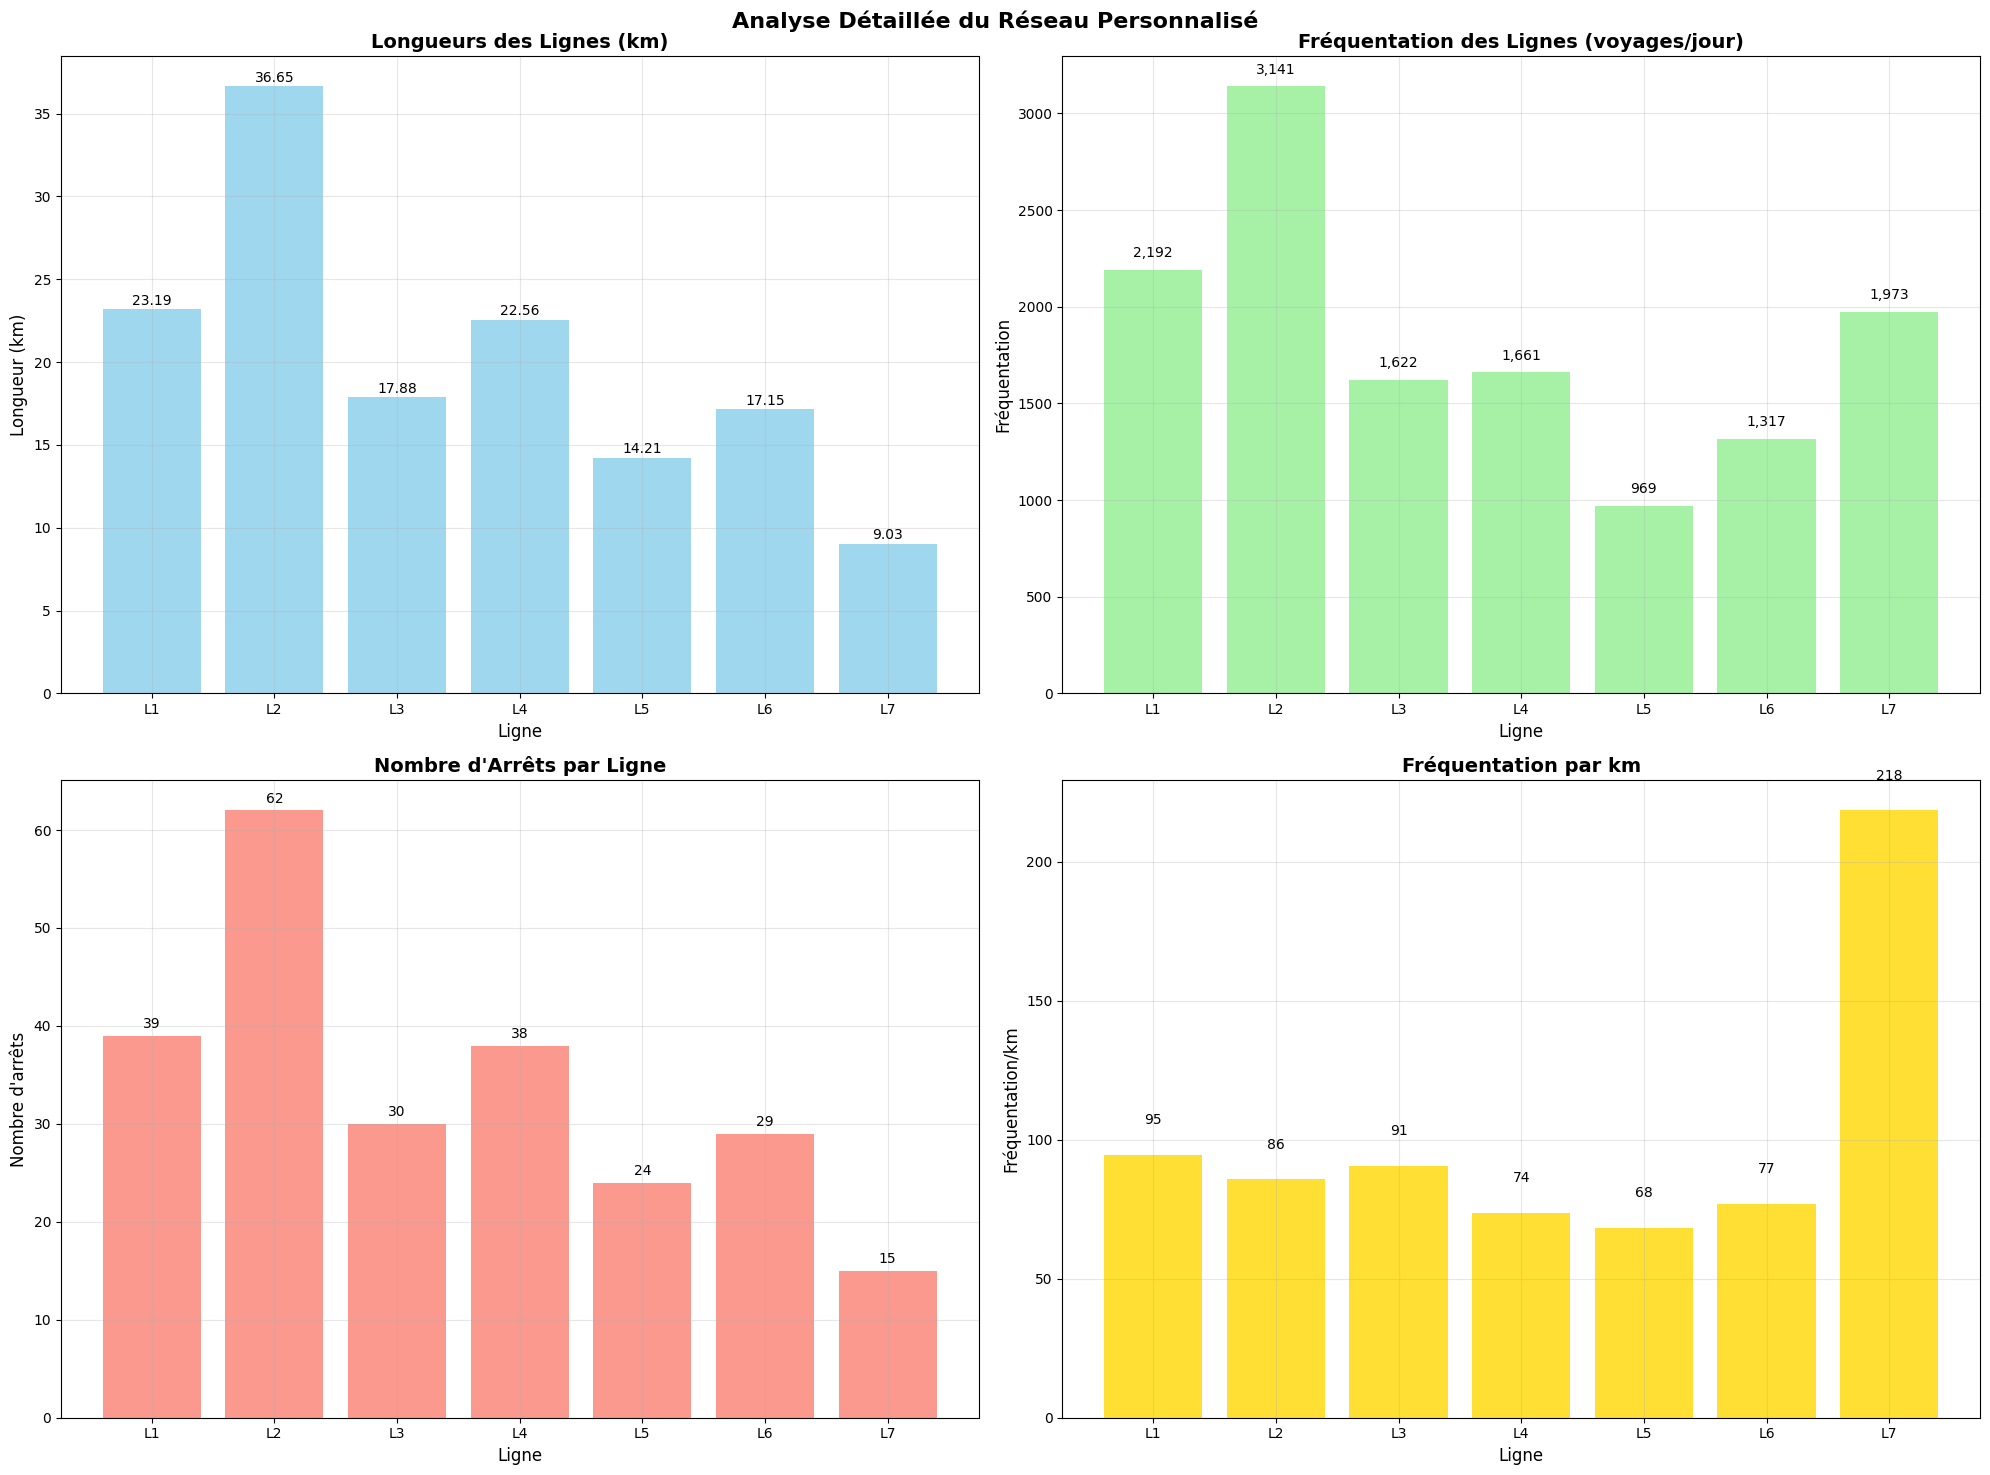

In [14]:
# ============================================================================
# **Analyse détaillée du réseau personnalisé**
# ============================================================================

def plot_network_stats(network):
    """Visualise les statistiques du réseau personnalisé."""
    # Longueurs des lignes
    lengths_km = [corridor['length_m'] / 1000 for corridor in network]

    # Fréquentation des lignes
    riderships = [calculate_line_ridership(corridor, stop_catchment_radius_m) for corridor in network]

    # Nombre d'arrêts par ligne
    stops_count = [len(corridor['stops']) for corridor in network]

    # Fréquentation par km
    ridership_per_km = [riderships[i] / lengths_km[i] for i in range(len(network))]

    # Création des graphiques
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))

    # Graphique 1: Longueurs des lignes
    ax1 = axes[0, 0]
    bars1 = ax1.bar(range(len(network)), lengths_km, color='skyblue', alpha=0.8)
    ax1.set_title('Longueurs des Lignes (km)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Ligne', fontsize=12)
    ax1.set_ylabel('Longueur (km)', fontsize=12)
    ax1.set_xticks(range(len(network)))
    ax1.set_xticklabels([f'L{i+1}' for i in range(len(network))])
    ax1.grid(True, alpha=0.3)
    for i, bar in enumerate(bars1):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 f'{lengths_km[i]:.2f}', ha='center', va='bottom', fontsize=10)

    # Graphique 2: Fréquentation des lignes
    ax2 = axes[0, 1]
    bars2 = ax2.bar(range(len(network)), riderships, color='lightgreen', alpha=0.8)
    ax2.set_title('Fréquentation des Lignes (voyages/jour)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Ligne', fontsize=12)
    ax2.set_ylabel('Fréquentation', fontsize=12)
    ax2.set_xticks(range(len(network)))
    ax2.set_xticklabels([f'L{i+1}' for i in range(len(network))])
    ax2.grid(True, alpha=0.3)
    for i, bar in enumerate(bars2):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                 f'{riderships[i]:,}', ha='center', va='bottom', fontsize=10)

    # Graphique 3: Nombre d'arrêts par ligne
    ax3 = axes[1, 0]
    bars3 = ax3.bar(range(len(network)), stops_count, color='salmon', alpha=0.8)
    ax3.set_title('Nombre d\'Arrêts par Ligne', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Ligne', fontsize=12)
    ax3.set_ylabel('Nombre d\'arrêts', fontsize=12)
    ax3.set_xticks(range(len(network)))
    ax3.set_xticklabels([f'L{i+1}' for i in range(len(network))])
    ax3.grid(True, alpha=0.3)
    for i, bar in enumerate(bars3):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{stops_count[i]}', ha='center', va='bottom', fontsize=10)

    # Graphique 4: Fréquentation par km
    ax4 = axes[1, 1]
    bars4 = ax4.bar(range(len(network)), ridership_per_km, color='gold', alpha=0.8)
    ax4.set_title('Fréquentation par km', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Ligne', fontsize=12)
    ax4.set_ylabel('Fréquentation/km', fontsize=12)
    ax4.set_xticks(range(len(network)))
    ax4.set_xticklabels([f'L{i+1}' for i in range(len(network))])
    ax4.grid(True, alpha=0.3)
    for i, bar in enumerate(bars4):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                 f'{ridership_per_km[i]:.0f}', ha='center', va='bottom', fontsize=10)

    plt.suptitle('Analyse Détaillée du Réseau Personnalisé', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualiser les statistiques détaillées du réseau personnalisé
plot_network_stats(custom_network)
